## Fine-tuned BERT for hate speech detection ##

### Instructions

The data for the competition has been pre-partitioned into 3 sets: train,dev,test

The test data consists of two parts: public and private, the leaderboard will display the performance<br>
on the public part, and we will announce the final results on the private test set after 04/12/2024.<br>

*Files*

    train_2024.csv - the training set, 99000 rows
    dev_2024.csv - the development set, 11000 rows
    test_2024.csv - the test set, 12001 rows
    sample_submission_2024.csv - a sample submission file in the correct format

*Columns*

    id - column for the example_id within the set
    text - the text of the comment
    label - binary label (1=Toxic/0=NonToxic)


In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import time
import datetime
import random
import os


In [2]:
# --- Debug cuda issues ---
#!nvcc --version
#import torch
#print(torch.__version__)
#print(torch.version.cuda)
#print(torch.cuda.is_available())
#print(torch.cuda.device_count())
#print(torch.cuda.get_device_name(0))

In [3]:

import matplotlib.pyplot as plt
from transformers import BertTokenizer
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup

In [4]:
#!pip install transformers

## Check is GPU available

In [5]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print('Running with %s, %d GPU available.' % (device, torch.cuda.device_count()))
    print('GPU:', torch.cuda.get_device_name(0))
else:
    print('No GPU detected! use colab or some other env')

Running with cuda, 1 GPU available.
GPU: NVIDIA GeForce RTX 2070 Super with Max-Q Design


In [6]:
df = pd.read_csv("./train/train_2024.csv", quoting=3, index_col=0)

In [7]:
# test with small amount of sentences
df = df.iloc[:5000]

In [8]:
pd.set_option('display.max_colwidth', 100)
df.head(10)

,text,label
id,,
0,Except that Desmond played first base last night. Tapia was in LF and Reynolds had a night off.,0
1,What i find funny is the loyalty and blindness of english community. The worst possible choice f...,0
2,Read the article not just the headline & you will find out.,0
3,Speaking of a horses backside is that where your head is at?,1
4,Michael Barone- gee are you dumb. No other words needed.,1
5,too bad ignorant left wing sheep like you in the usa are suckered every day by the reality of LO...,1
6,This is just another attempt to shut down speech the Democrats don't agree with. The effect it ...,1
7,Ugly American.....Trump's ugly presence and mean spiritedness has breathed new life into this te...,1
8,Yep. Go be cannon fodder due to being born poor. You are a piece of real sad humanity.,0


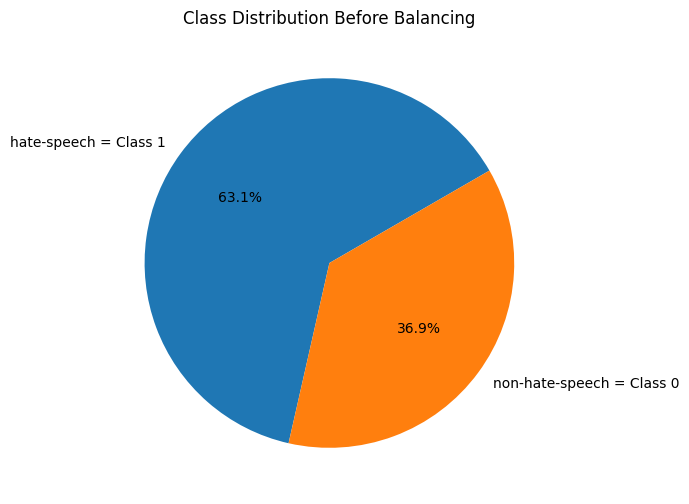

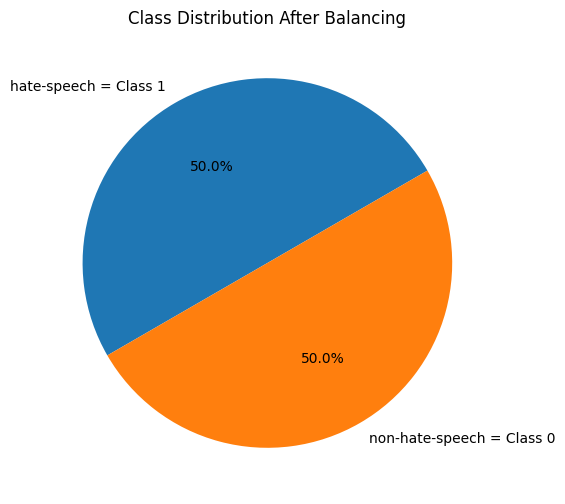

In [9]:

# let's visualize the class distribution
class_counts = df['label'].value_counts()
label = df['label'].values
text = df['text'].values

# pie chart
plt.figure(figsize=(8, 6))
plt.pie(class_counts, labels=['hate-speech = Class 1', 'non-hate-speech = Class 0'], autopct='%1.1f%%', startangle=30)
plt.title('Class Distribution Before Balancing')
plt.show()

# number of data points in the minority class
min_class_count = class_counts.min()

# balance the dataset
df_balanced = pd.concat([
    df[df['label'] == 0].sample(min_class_count, random_state=42),
    df[df['label'] == 1].sample(min_class_count, random_state=42)
])

# after balancing
class_counts_balanced = df_balanced['label'].value_counts()

# pie chart for the balanced dataset
plt.figure(figsize=(8, 6))
plt.pie(class_counts_balanced, labels=['hate-speech = Class 1', 'non-hate-speech = Class 0'], autopct='%1.1f%%', startangle=30)
plt.title('Class Distribution After Balancing')
plt.show()

df_balanced

label = df_balanced['label'].values
text = df_balanced['text'].values


### Later!!! try balancing class weights instead of just dropping datapoints

In [10]:
# uncomment below to normalize by weights

#class_wts = compute_class_weight(class_weight="balanced", classes=np.unique(train_labels), y=train_labels)
#weights = torch.tensor(class_wts, dtype=torch.float)
#weights = weights.to(device)

#cross_entropy = nn.NLLLoss(weight=weights)

## Pre-processing

In [11]:
#!pip install clean-text
#!pip install Unidecode
#!pip install spacy

### Clean the data

In [13]:
import numpy as np
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re

# lemmatizer
lemmatizer = WordNetLemmatizer()

# stopwords (this, that, at..)
stop_words = set(stopwords.words('english'))

# maintain some stopwords that might be useful for hatespeech detection
words_to_retain = {"not", "no", "never", "none", "he", "she", "they", "them", "but", "against", "without", "is", "are", "was", "were"}

# remove above important words from the stop words set
stop_words = {word for word in stop_words if word not in words_to_retain}

def clean_text_special(text):
    # Lowercase the text
    text = text.lower()
    
    # remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)  # Remove URLs
    
    # remove numbers (but leave special characters that could refer to curse words)
    text = re.sub(r'\d+', '', text)  # Remove digits
    
    # tokenize the text
    tokens = word_tokenize(text)
    
    # remove stopwords and lemmatize, keeping special characters
    cleaned_tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words and (token.isalnum() or re.match(r'[@#$%^&*]', token))]
    
    # join tokens back into a single string, keeping special characters
    cleaned_text = ' '.join(cleaned_tokens)
    
    return cleaned_text

def clean_numpy_texts(texts_array):
    vectorized_clean = np.vectorize(clean_text_special)  # vectorize the cleaning function for efficiency
    return vectorized_clean(texts_array)

text_clean = clean_numpy_texts(text)
print("cleaned len:", len(text_clean))
print("org len:", len(text))


cleaned len: 3688
org len: 3688


In [14]:
# save cleaned numpy array to file
np.save('text_clean.npy', text_clean)

In [15]:
# load numpy array from the file
text_clean = np.load('text_clean.npy')

print(text_clean[0])
print("num of sentences:", len(text_clean))

kalihi bad day
num of sentences: 3688


In [16]:
#tokenizer_cased = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case=False)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

### tokenization example

In [17]:
# these "##"" marks mean that the sub words are part of the previous token 
# motivate -> 'mo', '##tiv', '##ate'
# 101 is start token [CLS]
# 102 is end token [SEP]
tokens = tokenizer.tokenize(text_clean[0])
token_ids = tokenizer.convert_tokens_to_ids(tokens)
token_ids2 = [tokenizer.cls_token_id] + token_ids + [tokenizer.sep_token_id]
print(tokens)
print("[CLS] + %s + [SEP]" %(token_ids))
print(token_ids2)

['kali', '##hi', 'bad', 'day']
[CLS] + [19924, 4048, 2919, 2154] + [SEP]
[101, 19924, 4048, 2919, 2154, 102]


In [18]:
def tokenize_texts(texts_array, tokenizer):

    tokenized_texts = []
    for textline in texts_array:
        # Tokenize the text
        tokens = tokenizer.tokenize(textline)
        # Convert tokens to their IDs
        token_ids = tokenizer.convert_tokens_to_ids(tokens)
        # Optionally add special tokens (e.g., [CLS], [SEP]) if necessary for your model's input
        token_ids = [tokenizer.cls_token_id] + token_ids + [tokenizer.sep_token_id]
        tokenized_texts.append(token_ids)
   
    # convert list of tokenized text IDs into a numpy array
    tokenized_texts_array = np.array(tokenized_texts, dtype=object)
    
    return tokenized_texts_array

token_vectors = tokenize_texts(text_clean,tokenizer)

In [19]:
print("texts:\n", text_clean[:][0])
print("Tokenized Texts:\n", token_vectors[0])

texts:
 kalihi bad day
Tokenized Texts:
 [101, 19924, 4048, 2919, 2154, 102]


### Check the length distribution of token_vectors

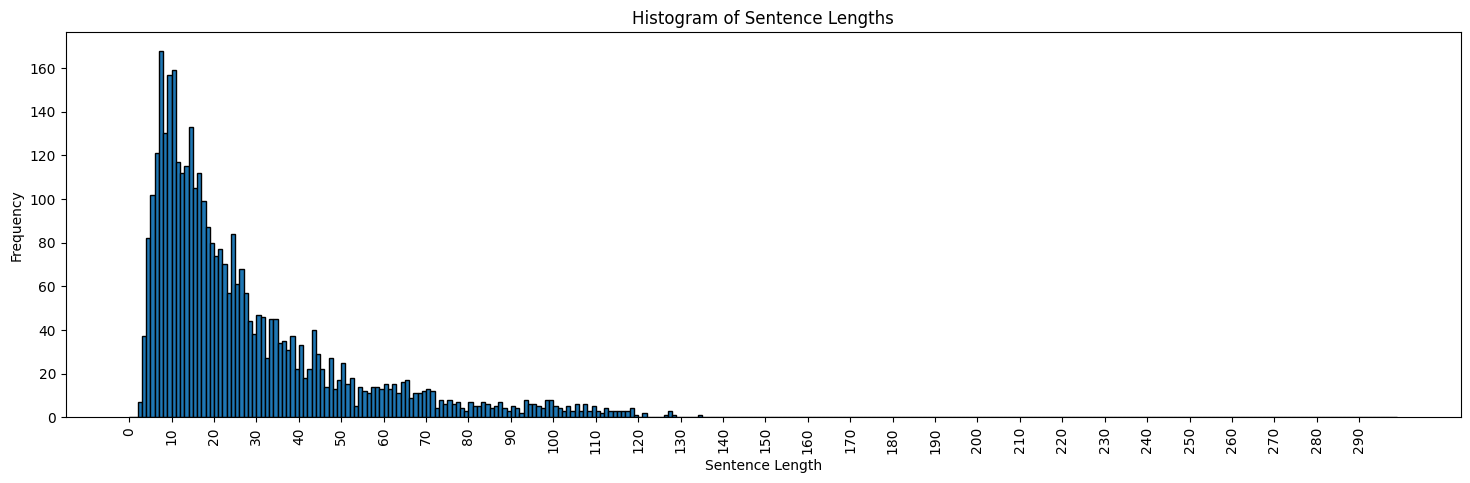

In [20]:
def sentence_len(ids):
    sentence_lengths = [len(sen) for sen in ids]
    maxbin = 300

    # histogram
    plt.figure(figsize=(18, 5))  # Set the figure size (optional)
    plt.hist(sentence_lengths, bins=range(0, maxbin), edgecolor='black')  # Ensure bins include the maxbin value
    plt.title('Histogram of Sentence Lengths')
    plt.xlabel('Sentence Length')
    plt.ylabel('Frequency')

    # Set x-axis ticks to every 10th value. Adjust the range as needed.
    plt.xticks(range(0, maxbin, 10))  # Starts from 1, goes up to maxbin, steps by 10
    
    plt.xticks(rotation=90)  # Rotate x-axis labels for better readability

    plt.show()

sentence_len(token_vectors)

**truncate token vectors longer than given max length (140 tokens)**<br>
**pad token vectors shorter than max lenght with zeros to max lenght (140)**

In [21]:
def custom_pad_sequences(sequences, maxlen=280, padding_value=0):

    processed_seqs = []
    
    for seq in sequences:
        # truncate if necessary
        if len(seq) > maxlen:
            processed_seq = seq[:maxlen]
        else:
            processed_seq = seq
            
        # pad if necessary
        padded_seq = processed_seq + [padding_value] * (maxlen - len(processed_seq))
        processed_seqs.append(padded_seq)
        
    return processed_seqs


MAX_LEN = 140

print(f'\nPadding/truncating all sentences to {MAX_LEN} length')
print(f'Padding token: "{tokenizer.pad_token}", ID: {tokenizer.pad_token_id}')

# Pad our input tokens with value 0.
padded_token_vectors = custom_pad_sequences(token_vectors, maxlen=MAX_LEN, padding_value=0)



Padding/truncating all sentences to 140 length
Padding token: "[PAD]", ID: 0


In [22]:
padded_token_vectors[:][0]

[101,
 19924,
 4048,
 2919,
 2154,
 102,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [23]:
attention_masks = []

for sent in padded_token_vectors:
    att_mask = [int(token_id > 0) for token_id in sent]
    
    # append attention mask for the sentences.
    attention_masks.append(att_mask)

In [24]:
print(len(label))
print(len(padded_token_vectors))

3688
3688


In [25]:

X_train, X_val, y_train, y_val = train_test_split(padded_token_vectors, label, random_state=2018, test_size=0.2)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, label, random_state=2018, test_size=0.2)

In [26]:
train_inputs = torch.tensor(X_train)
validation_inputs = torch.tensor(X_val)

train_labels = torch.tensor(y_train)
validation_labels = torch.tensor(y_val)

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [27]:

batch_size = 16

# dataLoader for training set.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# dataLoader for validation set.
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [28]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [29]:

model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", 
    num_labels = 2, 
    output_attentions = False, 
    output_hidden_states = False, 
)

model.cuda()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [30]:

params = list(model.named_parameters())

print('{:} parameters.\n'.format(len(params)))

print('Embedding Layer\n')
for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\nTransformers\n')
for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\nOutput Layer\n')
for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

201 parameters.

Embedding Layer

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

Transformers

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (768,)
bert.encoder.layer.0.attention.output.LayerNorm.weight

In [31]:
optimizer = torch.optim.AdamW(model.parameters(),
                              lr=5e-5,  # args.learning_rate - default in PyTorch is also 1e-3
                              eps=1e-8  # args.adam_epsilon - default in PyTorch is 1e-8
                             )

In [32]:
epochs = 3
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, num_training_steps = total_steps)

In [33]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [34]:
def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [36]:

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

loss_values = []

for epoch_i in range(0, epochs):
    
    ### Training
    
    # Perform one full pass over the training set.

    print("")
    print('Epoch {:} / {:} '.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()

    total_loss = 0
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        if step % 40 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # `batch` contains three pytorch tensors:
        #   [0]: ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()        

        outputs = model(b_input_ids, 
                    token_type_ids=None, 
                    attention_mask=b_input_mask, 
                    labels=b_labels)
        
        loss = outputs[0]
        total_loss += loss.item()
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_loss / len(train_dataloader)            
    
    loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
        

    ### Validation
    print("Running Validation...")

    t0 = time.time()
    model.eval()

    # variables 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # to GPU
        batch = tuple(t.to(device) for t in batch)
        
        b_input_ids, b_input_mask, b_labels = batch

        with torch.no_grad():        

            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        logits = outputs[0]

        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        eval_accuracy += tmp_eval_accuracy
        nb_eval_steps += 1

    # Report the final accuracy for this validation run.
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")


Epoch 1 / 3 
Training...
  Batch    40  of    185.    Elapsed: 0:00:14.
  Batch    80  of    185.    Elapsed: 0:00:28.
  Batch   120  of    185.    Elapsed: 0:00:42.
  Batch   160  of    185.    Elapsed: 0:00:56.

  Average training loss: 0.39
  Training epcoh took: 0:01:05
Running Validation...
  Accuracy: 0.92
  Validation took: 0:00:05

Epoch 2 / 3 
Training...
  Batch    40  of    185.    Elapsed: 0:00:15.
  Batch    80  of    185.    Elapsed: 0:00:33.
  Batch   120  of    185.    Elapsed: 0:00:51.
  Batch   160  of    185.    Elapsed: 0:01:09.

  Average training loss: 0.19
  Training epcoh took: 0:01:20
Running Validation...
  Accuracy: 0.90
  Validation took: 0:00:07

Epoch 3 / 3 
Training...
  Batch    40  of    185.    Elapsed: 0:00:18.
  Batch    80  of    185.    Elapsed: 0:00:37.
  Batch   120  of    185.    Elapsed: 0:00:55.
  Batch   160  of    185.    Elapsed: 0:01:13.

  Average training loss: 0.11
  Training epcoh took: 0:01:24
Running Validation...
  Accuracy: 0.93
 